In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

import cvxpy as cp

from mie2c.e2c import E2C, compute_loss, PWATransition
from mie2c.cartpole_model import (get_cartpole_encoder, get_cartpole_decoder,
    get_cartpole_transition, get_cartpole_linear_transition, get_cartpole_pwa_transition)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Run `python generate_cartpole_data.py N --torque_control` where `N` is the number of desired samples 

In [5]:
# load data generated for the cartpole
X0 = np.load('data/cartpole_X0.npy')
X_all = np.load('data/cartpole_X.npy')
U_all = np.load('data/cartpole_U.npy')
X_next_all = np.load('data/cartpole_X_next.npy')

# test_ratio = .01
# test_indx = int(test_ratio * X_all.shape[0])
test_indx = 100

X0 = torch.tensor(X0, dtype=torch.float) / 255.
X_test = torch.tensor(X_all[:test_indx, :, :, :], dtype=torch.float)
U_test = torch.tensor(U_all[:test_indx, :], dtype=torch.float)
X_next_test = torch.tensor(X_next_all[:test_indx, :, :, :], dtype=torch.float)

X = torch.tensor(X_all[test_indx:, :, :, :], dtype=torch.float)
U = torch.tensor(U_all[test_indx:, :], dtype=torch.float)
X_next = torch.tensor(X_next_all[test_indx:, :, :, :], dtype=torch.float)

NUM_TEST = X_test.shape[0]
NUM_DATA = X.shape[0]

dataset = torch.utils.data.TensorDataset(X, U, X_next)

In [6]:
C,W,H = X.shape[1:]

dim_in = X[0].shape
dim_z = 6
dim_u = 1
use_cuda = False

In [6]:
def show_samples(X_samples, X_next_samples=None):
    num_samples = X_samples.shape[0]
    fig = plt.figure(figsize=(10,10))
    for k in range(num_samples):
        if X_next_samples is not None:
            fig.add_subplot(num_samples,3,k*3+1)
            plt.imshow(X_samples[k,:3,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))
            fig.add_subplot(num_samples,3,k*3+2)
            plt.imshow(X_samples[k,3:,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))
            fig.add_subplot(num_samples,3,k*3+3)
            plt.imshow(X_next_samples[k,3:,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))
        else:
            fig.add_subplot(num_samples,2,k*2+1)
            plt.imshow(X_samples[k,:3,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))
            fig.add_subplot(num_samples,2,k*2+2)
            plt.imshow(X_samples[k,3:,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))
    plt.show()

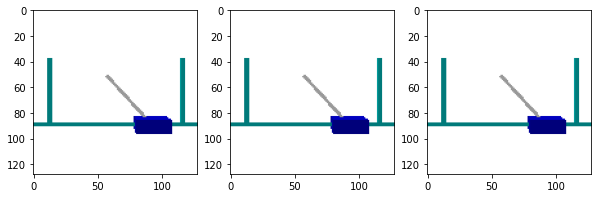

In [22]:
idx = [np.random.randint(NUM_DATA)]
show_samples(X[idx,:,:,:], X_next[idx,:,:,:])

In [7]:
use_low_rank = False  # True if A = I + r*v^T
num_modes = 3

encoder = get_cartpole_encoder(dim_in, dim_z)
pwa_transition = get_cartpole_pwa_transition(num_modes, dim_z, dim_u, low_rank=use_low_rank)
decoder = get_cartpole_decoder(dim_z, dim_in) 

fn_pwa = 'model_pwa'
model_pwa = E2C(encoder, pwa_transition, decoder)

# if os.path.exists('pytorch/{}.pt'.format(fn_pwa)):
#     model_pwa.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_pwa)))

# Train PWA model

In [24]:
def train_vae(model, model_name, dataset, verbose=True, cuda=False):
    if not os.path.exists('pytorch'):
        os.makedirs('pytorch')
    fn_pt_model = 'pytorch/{}.pt'.format(model_name)
    dim_u = model.trans.dim_u

    # training parameters
    NUM_EPOCH = 100
    BATCH_SIZE = 64
    CHECKPOINT_AFTER = 10
    SAVEPOINT_AFTER = 20

    KL_LAMBDA = .25
    TEMP_LAMBDA = 10.

    if cuda:
        model = model.to("cuda")

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(model.parameters())

    itr = 0
    for epoch in range(NUM_EPOCH):
        for x, u, x_next in dataloader:
            optimizer.zero_grad()

            model(x, u, x_next)
            elbo_loss, kl_loss = compute_loss(model.x_dec, model.x_next_dec, model.x_next_pred_dec,
                                              x / 255., x_next / 255.,
                                              model.Qz, model.Qz_next, model.Qz_next_pred)
            loss = elbo_loss + KL_LAMBDA * kl_loss
            if isinstance(model.trans, PWATransition):
                loss += TEMP_LAMBDA * model.trans.temperature.pow(2)[0]

            loss.backward()
            optimizer.step()

            if itr % CHECKPOINT_AFTER == 0:
                print('Avg. loss: {}'.format(loss.item()))

            if itr % SAVEPOINT_AFTER == 0:
                torch.save(model.state_dict(), fn_pt_model)

            itr += 1

    torch.save(model.state_dict(), fn_pt_model)

In [30]:
train_vae(model_pwa, fn_pwa, dataset, verbose=True, cuda=False)

Avg. loss: 4302222.407586278


KeyboardInterrupt: 

# Run MICP controller

In [23]:
num_modes = len(model_pwa.trans.As)
N = 6 # Horizon for controller

Aks, Bks, oks = [], [], []
Ws, bs = [], []
for ii in range(num_modes):
    Aks.append(model_pwa.trans.As[0].detach().numpy())
    Bks.append(model_pwa.trans.Bs[0].detach().numpy())
    oks.append(model_pwa.trans.os[0].detach().numpy().flatten())
    Ws.append(model_pwa.trans.mode_classifier.weight[ii].detach().numpy().flatten())
    bs.append(model_pwa.trans.mode_classifier.weight[ii].detach().numpy().flatten())

In [53]:
M = np.maximum((model_pwa.trans.mode_classifier.weight.abs().max() + model_pwa.trans.mode_classifier.bias.abs().max()).detach().numpy(), 1e4)

z = cp.Variable((dim_z, N))
u = cp.Variable((dim_u, N-1))
y = cp.Variable((num_modes, N-1), boolean=True)

z0 = cp.Parameter(dim_z)
zg = cp.Parameter(dim_z)

cons = []

# Initial condition
cons += [z[:,0] == z0]

# Dynamics constraints
for ii in range(N-1):
    cons += [cp.sum(y[:,ii]) == 1]
    for jj in range(num_modes):
        Ak, Bk, ok = Aks[jj], Bks[jj], oks[jj]      
        cons += [Ak @ z[:,ii] + Bk @ u[:,ii] + ok - z[:,ii+1] <= M*(cp.sum(y[:,ii]) - y[jj,ii])]
        cons += [z[:,ii+1] - (Ak @ z[:,ii] + Bk @ u[:,ii] + ok) <= M*(cp.sum(y[:,ii]) - y[jj,ii])]

# Piecewise affine constraints
for ii in range(num_modes):
    w_ii, b_ii = Ws[ii], bs[ii]
    for jj in range(num_modes):
        if ii == jj:
            continue
        w_jj, b_jj = Ws[jj], bs[jj]
        for kk in range(N-1):
            cons += [w_jj @ z[:,kk] + b_jj - (w_ii @ z[:,kk] + b_ii) <= M*(cp.sum(y[:,ii]) - y[jj,ii])]

# Control constraints
force_max = 10.
for ii in range(N-1):
    cons += [cp.abs(u[:,ii]) <= force_max]

# LQR cost
lqr_cost = 0.
Q = np.eye(dim_z)
R = 0.1
for ii in range(1,N):
    lqr_cost += cp.quad_form(z[:,ii]-zg, Q)
for ii in range(N-1):
    lqr_cost += R*cp.abs(u[0,ii])

bin_prob = cp.Problem(cp.Minimize(lqr_cost), cons)
bin_prob_params = {'z0':z0, 'zg':zg}

In [27]:
bin_prob_params['z0'].value = model_pwa.encode(X_test[0,:,:,:].unsqueeze(0))[0].detach().numpy().flatten()
bin_prob_params['zg'].value = model_pwa.encode(X0[0,:,:,:].unsqueeze(0))[0].detach().numpy().flatten()

In [28]:
n_rollouts = 10
mpc_imgs = torch.zeros((n_rollouts+2,C,W,H))

mpc_imgs[0] = X_test[0,:,:,:]
mpc_imgs[-1] = X0[0,:,:,:]

for ii in range(n_rollouts):
    bin_prob.solve(solver=cp.GUROBI)
    print(bin_prob.value)
    if bin_prob.status not in ['optimal', 'feasible']:
        break

    img_out = model_pwa.decode(torch.tensor(z.value[:,1], dtype=torch.float).unsqueeze(0))
    mpc_imgs[ii+1] = img_out

    # Update initial condition for MICP
    bin_prob_params['z0'].value = z.value[:,1]

Academic license - for non-commercial use only - expires 2021-05-17
Using license file /Users/acauligi/gurobi.lic
216210.36176428522
2331684.2689093566
37815495.74061254
1089043481.3650239
30651527559.777245
1001095455830.929
inf


/Users/acauligi/Dropbox/2019_20/spring_20/cs_231n/project/cs231n-project/cs231n_project/lib/python3.7/site-packages/cvxpy/problems/problem.py:1246: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


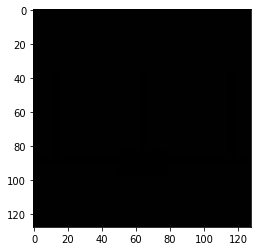

In [29]:
plt.imshow(mpc_imgs[-1,3:,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))